# Stroke EDA & Prediction

A stroke is a medical condition in which poor blood flow to the brain causes cell death. There are two main types of stroke: ischemic, due to lack of blood flow, and hemorrhagic, due to bleeding. Both cause parts of the brain to stop functioning properly. Signs and symptoms of a stroke may include an inability to move or feel on one side of the body, problems understanding or speaking, dizziness, or loss of vision to one side. Signs and symptoms often appear soon after the stroke has occurred. If symptoms last less than one or two hours, the stroke is a transient ischemic attack (TIA), also called a mini-stroke. A hemorrhagic stroke may also be associated with a severe headache. The symptoms of a stroke can be permanent. Long-term complications may include pneumonia and loss of bladder control.



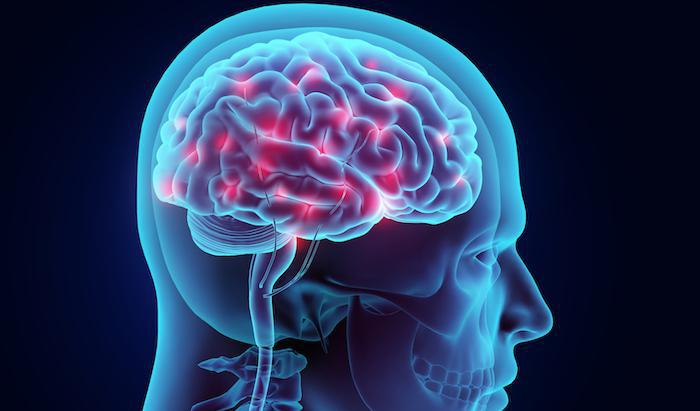


1. [Libraries and Utilities](#1)
2. [Load and Check Data](#2)
3. [Variable Description](#3)
4. [Missing Values](#4)
5. [Exploratory Data Analysis](#5)
    * [Stroke - Avg Glucose Level - BMI](#10)
    * [Age Distribution](#28)
    * [Avg Glucose Level Distribution](#29)
    * [BMI Distribution](#30)
    * [Stroke - Gender](#8)
    * [Age - Avg Glucose Level - BMI](#12)
    * [Gender - Age - Avg Glucose Level - BMI](#6)
    * [Gender - Marriage - Work Type - Residence Type - Smoking Status](#7)
    * [Correlation Map](#11)
6. [Outliers](#13)
6. [Feature Engineering](#14)
7. [Preprocessing](#20)
    * [Train - Test Split](#21)
    * [Standardization](#22)
8. [LightGBM Classification](#23)
    * [Initiate Model](#24)
    * [Confusion Matrix](#26)

<a id = "1"></a>
# Libraries and Utilities

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from collections import Counter

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id = "2"></a>
# Load and Check Data

In [ ]:
df  = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

df.head(10)

In [ ]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

In [ ]:
df.info()

In [ ]:
describe = df.describe()
describe.T

<a id = "3"></a>
# Variable Description
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.


1) id: unique identifier   
2) gender: "Male", "Female" or "Other"   
3) age: age of the patient   
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension   
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease   
6) ever_married: "No" or "Yes"   
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"   
8) Residence_type: "Rural" or "Urban"   
9) avg_glucose_level: average glucose level in blood   
10) bmi: body mass index   
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*   
12) stroke: 1 if the patient had a stroke or 0 if not   
**Note:** "Unknown" in smoking_status means that the information is unavailable for this patient   

<a id = "4"></a>
# Missing Values

In [ ]:
print(df.isna().sum())

In [ ]:
DT_bmi_pipe = Pipeline( steps=[('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

df.isna().sum()

In [ ]:
df.head()

<a id = "5"></a>
# Exploratory Data Analysis

- There are many categorical variables in dataset.
- Nominal variables: gender, ever_married, work_type, Residence_type, smoking status
- Ordinal variables: hypertension, heart_disease
- There is only 1 "Other" in gender.

In [ ]:
df[df["gender"] == "Other"]

In [ ]:
df2 = df.copy()
df2 = df2.loc[df["gender"] != "Other"]
df2.shape

<a id = "10"></a>
## Stroke - Avg Glucose Level - BMI

In [ ]:
stroke = df["stroke"].astype(str)

stroke_1 = df[stroke == "0"]
stroke_2 = df[stroke == "1"]

plt.figure(figsize = (12,6))
plt.scatter(stroke_1["avg_glucose_level"],stroke_1["bmi"],label= "Stroke: 0", color="cornflowerblue", alpha=0.75 )
plt.scatter(stroke_2["avg_glucose_level"],stroke_2["bmi"], label = "Stroke: 1", color="deeppink", alpha=0.75)

plt.title("Stroke - Avg Glucose Level - BMI")
plt.xlabel("Avg Glucose Level")
plt.ylabel("BMI")
plt.legend()
plt.show()

<a id = "28"></a>
## Age Distribution

In [ ]:
plt.figure(figsize = (12,6))
plt.hist(df["age"], bins = 50, color = "firebrick")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution", size = 12)
plt.show()

<a id = "29"></a>
## Avg Glucose Level Distribution

In [ ]:
plt.figure(figsize = (12,6))
plt.hist(df["avg_glucose_level"], bins = 50, color = "firebrick")
plt.xlabel("Avg Glucose Level")
plt.ylabel("Frequency")
plt.title("Avg Glucose Level Distribution", size = 12)
plt.show()

<a id = "30"></a>
## BMI Distribution

In [ ]:
plt.figure(figsize = (12,6))
plt.hist(df["bmi"], bins = 50, color = "firebrick")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("BMI Distribution", size = 12)
plt.show()

<a id = "8"></a>
## Stroke - Gender

In [ ]:
stroke = df2["stroke"].value_counts()
gender = df2["gender"].value_counts()

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(x= stroke, autopct="%.2f%%", labels=stroke.keys(), pctdistance=0.6)
plt.title('Stroke', size = 14)

ax1 = plt.subplot2grid((2,2), (0, 1))
plt.pie(x =gender,autopct="%.2f%%", labels=gender.keys(), pctdistance=0.6)
plt.title('Gender', size = 14)
plt.show()

<a id = "12"></a>
## Age - Avg Glucose Level - BMI

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(ax=axes[0], x = df2["age"])
axes[0].set_title("Age")

sns.distplot(ax=axes[1],x = df2["avg_glucose_level"])
axes[1].set_title("Avg Glucose Level")

sns.distplot(ax=axes[2],x = df2["bmi"])
axes[2].set_title("BMI")
plt.show()

<a id = "6"></a>
## Gender - Age - Avg Glucose Level - BMI

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], x = df2["gender"], y = df2["age"], palette = "Set1")
axes[0].set_title("Gender - Age")

sns.boxplot(ax=axes[1], x = df2["gender"],y = df2["avg_glucose_level"], palette = "Set1")
axes[1].set_title("Gender - Avg Glucose Level")

sns.boxplot(ax=axes[2], x = df2["gender"],y = df2["bmi"], palette = "Set1")
axes[2].set_title("Gender -  BMI")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.violinplot(ax=axes[0], x = df2["gender"], y = df2["age"], palette = "Set1")
axes[0].set_title("Gender - Age")

sns.violinplot(ax=axes[1], x = df2["gender"],y = df2["avg_glucose_level"], palette = "Set1")
axes[1].set_title("Gender - Avg Glucose Level")

sns.violinplot(ax=axes[2], x = df2["gender"],y = df2["bmi"], palette = "Set1")
axes[2].set_title("Gender -  BMI")
plt.show()

<a id = "7"></a>
## Gender - Marriage - Work Type - Residence Type - Smoking Status

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.countplot(ax=axes[0, 0], data=df2, x='gender', hue='ever_married',palette = "Spectral")
axes[0, 0].set_title("Gender - Marriage")
sns.countplot(ax=axes[0, 1], data=df2, x='gender', hue='work_type',palette = "Spectral")
axes[0, 1].set_title("Gender - Work Type")
sns.countplot(ax=axes[1, 0], data=df2, x='gender', hue='Residence_type',palette = "Spectral")
axes[1, 0].set_title("Gender - Residence Type")
sns.countplot(ax=axes[1, 1], data=df2, x='gender', hue='smoking_status',palette = "Spectral")
axes[1, 1].set_title("Gender - Smoking Status")

plt.show()

<a id = "11"></a>
## Correlation Map

In [ ]:
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot= True,
            fmt = ".2f",
            ax=ax,
            vmin = -1,
            vmax = 1,
            cmap = "coolwarm")
plt.xticks(rotation=60, size = 12)
plt.yticks(rotation=0, size  = 12)
plt.title('Correlation Map', size = 14)
plt.show()

<a id = "13"></a>
# Outliers

In [ ]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        
        Q1 = np.percentile(df[c],10)
        Q3 = np.percentile(df[c],90)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
df.loc[detect_outliers(df,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke'])]

In [ ]:
df = df.drop(detect_outliers(df,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']),axis = 0).reset_index(drop = True)

<a id = "14"></a>
# Feature Engineering

In [ ]:
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)

df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

df.head()

<a id = "20"></a>
# Preprocessing
<a id = "21"></a>
## Train-Test Split

In [ ]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ranUnSample = RandomUnderSampler()
X_train, y_train = ranUnSample.fit_resample(X_train, y_train)

In [ ]:
print('X_train shape: {}'.format(X_train.shape))

In [ ]:
print('y_train shape: {}'.format(y_train.shape))

<a id = "22"></a>
## Scaling

In [ ]:
scaler = StandardScaler() #RobustScaler - StandardScaler

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id = "23"></a>
# LightGBM Classification
<a id = "24"></a>
## Initiate Model

In [ ]:
lgbm = LGBMClassifier(boosting_type = 'gbdt',
                     num_leaves = 31,
                     max_depth = -1,
                     learning_rate = 0.05,
                     n_estimators = 100)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

print(classification_report(y_test, y_pred))
print("LightGBM Classifier Accuracy: %{}".format(round(lgbm.score(X_test,y_test)*100,2)))

<a id = "26"></a>
## Confusion Matrix

In [ ]:
y_pred = lgbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df1 = pd.DataFrame(columns=["Not Stroke","Stroke"],
                   index= ["Not Stroke","Stroke"],
                   data= cm )

f,ax = plt.subplots(figsize=(6,3))
sns.heatmap(df1, annot=True,cmap="Blues",
            fmt= '.0f',linewidths = 5,ax=ax,
            cbar = False, annot_kws={'size':24})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()